In [1]:
import sys
import os
import requests
import numpy as np
import scipy
from scipy.ndimage import uniform_filter
import pandas as pd
import matplotlib.pyplot as plt
import copy



In [2]:
try:
  import pynumdiff
except:
  !pip install pynumdiff
  import pynumdiff

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 2.2 MB/s eta 0:00:00


In [4]:
try:
    import casadi
except:
    !pip install casadi
    import casadi

try:
    import do_mpc
except:
    !pip install do_mpc
    import do_mpc

try:
    import pybounds
except:
    #!pip install pybounds
    !pip install git+https://github.com/vanbreugel-lab/pybounds
    import pybounds

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.1/164.1 kB 4.0 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/do_mpc/sysid/__init__.py:15: UserWarning: The ONNX feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The ONNX feature is not available. Please install the full version of do-mpc to access this feature.')
/usr/local/lib/python3.12/dist-packages/do_mpc/opcua/__init__.py:14: UserWarning: The opcua feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The opcua feature is not available. Please install the full version of do-mpc to access this feature.')


  Cloning https://github.com/vanbreugel-lab/pybounds to /tmp/pip-req-build-fkl4lf39
  Running command git clone --filter=blob:none --quiet https://github.com/vanbreugel-lab/pybounds /tmp/pip-req-build-fkl4lf39
  Resolved https://github.com/vanbreugel-lab/pybounds to commit 96f12039ac9e1e3ef4381cd09a026f6bbf70ad5c
  Preparing metadata (setup.py) ... done
  Created wheel for pybounds: filename=pybounds-0.0.13-py3-none-any.whl size=19546 sha256=34301728a20310b52395bdc6ee5eb77eda95be9d4082fc6e6fd242c08988bc8b
  Stored in directory: /tmp/pip-ephem-wheel-cache-fu6xxbrq/wheels/cb/f8/fb/ff1887f9a2f35c3edad7b1acb7da69437c1fd8d885a800578d
Successfully built pybounds


In [5]:
import sys
import requests
import importlib

def import_local_or_github(package_name, function_name=None, directory=None, giturl=None):
    # Import functions directly from github
    # Important: note that we use raw.githubusercontent.com, not github.com

    try: # to find the file locally
        if directory is not None:
            if directory not in sys.path:
                sys.path.append(directory)

        package = importlib.import_module(package_name)
        if function_name is not None:
            function = getattr(package, function_name)
            return function
        else:
            return package

    except: # get the file from github
        if giturl is None:
            giturl = 'https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Utility/' + str(package_name) + '.py'

        r = requests.get(giturl)
        print('Fetching from: ')
        print(r)

        # Store the file to the colab working directory
        with open(package_name+'.py', 'w') as f:
            f.write(r.text)
        f.close()

        # import the function we want from that file
        package = importlib.import_module(package_name)
        if function_name is not None:
            function = getattr(package , function_name)
            return function
        else:
            return package

planar_drone = import_local_or_github('planar_drone', directory='../Utility')
plot_tme = import_local_or_github('plot_utility', 'plot_tme', directory='../Utility')
generate_training_data_utility = import_local_or_github('generate_training_data_utility', directory='../Utility')
terrain_and_optic_flow_utility = import_local_or_github('terrain_and_optic_flow_utility', directory='../Utility')

Fetching from: 
<Response [200]>
Fetching from: 
<Response [200]>
Fetching from: 
<Response [200]>


# Demonstrate terrain generation, ray tracing

In [6]:
terrain = terrain_and_optic_flow_utility.Terrain(seed=0)

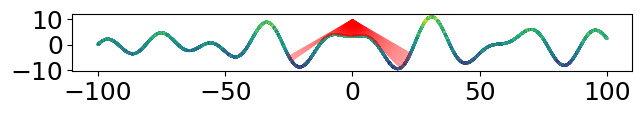

In [7]:
img = terrain_and_optic_flow_utility.get_image(terrain, [0, 10], plot=True)

# Analytic optic flow

Consider the following trigonometric relationship for an agent moving in the plane (from [Lingenfelter, Nag, & van Breugel](https://iopscience.iop.org/article/10.1088/1748-3190/ac1f7b/meta)):

![Optic flow](../images/optic_flow_lingenfelter.png "Optional title text")

For each ray we can write the following trigonometric relationship where $l$ and $d$ correspond to the lateral and frontal distance to a terrain feature:

$$
\tan(\alpha) = l/d.
$$

Taking the derivative with respect to time we find the following relationship for optic flow (angular image velocity):

$$
\dot{\alpha} = \bigg( \frac{ \frac{\delta}{\delta t} l }{d} - \frac{ l \frac{\delta}{\delta t} d }{d^2} \bigg) \cos^2(\alpha)
$$

Placing this in the context of our planar drone variables we have:

$$
\dot{\alpha} = \bigg( \frac{ \dot{x} }{z} - \frac{ z \tan(\alpha) \dot{z} }{z^2} \bigg) \cos^2(\alpha)
$$

# Demonstrate analytic optic flow patterns

In [8]:
terrain = terrain_and_optic_flow_utility.Terrain(x_min=-100, x_max=100, seed=0)

In [9]:
f = planar_drone.F(k=1).f
h = planar_drone.H('h_camera_imu', k=1).h

dt=0.1

t_sim, x_sim, u_sim, y_sim, simulator = planar_drone.simulate_drone(f, h, dt=dt,
                                                                    tsim_length=10, trajectory_shape='bigsquiggle', rterm=1e-3)

In [10]:
t_sim_df = pd.DataFrame({'time': t_sim})
y_sim_df = pd.DataFrame(y_sim)
u_sim_df = pd.DataFrame(u_sim)
x_sim_df = pd.DataFrame(x_sim)

objid = pd.DataFrame({'objid': (1*np.ones_like(t_sim)).astype(int)})

In [11]:
new_names = {key: 'sensor_' + key for key in y_sim_df}
y_sim_df = y_sim_df.rename(columns=new_names)

df = pd.concat([t_sim_df, objid, x_sim_df, u_sim_df, y_sim_df], axis=1)

trim_indices = 5
df_trimmed = df.iloc[trim_indices:-trim_indices]

trajec_squiggle = df_trimmed

### Optic flow for x movement

In [12]:
# build a trajectory that is just moving in x
trajec_constz = copy.copy(trajec_squiggle)
trajec_constz.z *= 0
trajec_constz.z += 5
_, trajec_constz.z_dot = pynumdiff.finite_difference.first_order(trajec_constz.z, dt)

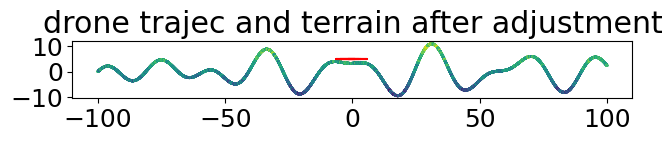

In [13]:
# plot trajec and terrain to verify
trajec_constz_adj = terrain_and_optic_flow_utility.adjust_trajec_altitude(trajec_constz, terrain, plot=True)

In [14]:
# find optic flow and ray distances for the whole trajectory
imgs, optic_flows, ray_distances = terrain_and_optic_flow_utility.get_imgs_and_analytic_optic_flows(trajec_constz_adj, terrain)

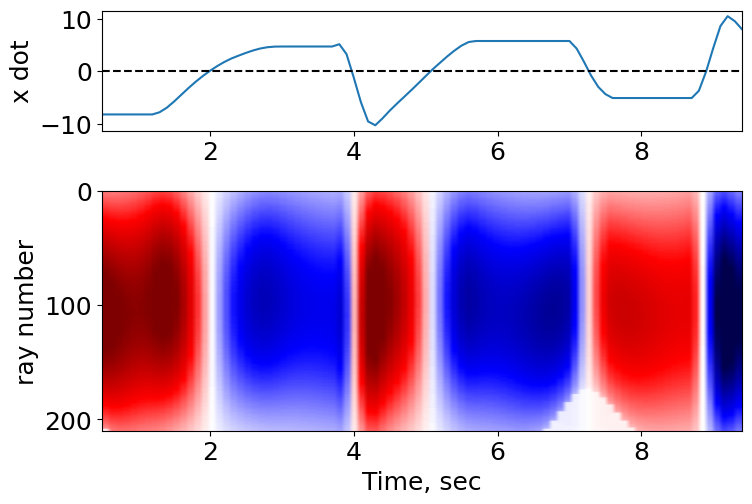

In [15]:
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_axes([0.2, 0.7, 0.8, 0.2])
ax2 = fig.add_axes([0.2, 0.2, 0.8, 0.4])

ax1.plot(trajec_constz_adj.time.values, trajec_constz_adj.x_dot.values)
ax1.set_xlim([trajec_constz_adj.time.values.min(), trajec_constz_adj.time.values.max()])
ax1.hlines(0, trajec_constz_adj.time.values.min(), trajec_constz_adj.time.values.max(),
           linestyles='--', colors='black')
ax1.set_ylabel('x dot')

ax2.imshow(optic_flows, vmin=-5, vmax=5, cmap='seismic', extent=[trajec_constz_adj.time.values.min(),
                                                                 trajec_constz_adj.time.values.max(),
                                                                 210, 0])
ax2.set_ylabel('ray number')
ax2.set_xlabel('Time, sec')

ax2.set_aspect('auto')

### Build a trajectory that only moves in z

In [16]:
# build a trajectory that is just moving in x
trajec_constx = copy.copy(trajec_squiggle)
trajec_constx.x *= 0
_, trajec_constx.x_dot = pynumdiff.finite_difference.first_order(trajec_constx.x, dt)

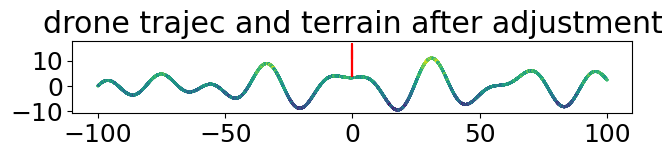

In [17]:
# plot trajec and terrain to verify
trajec_constx_adj = terrain_and_optic_flow_utility.adjust_trajec_altitude(trajec_constx, terrain, plot=True)

In [18]:
# find optic flow and ray distances for the whole trajectory
imgs, optic_flows, ray_distances = terrain_and_optic_flow_utility.get_imgs_and_analytic_optic_flows(trajec_constx_adj, terrain)

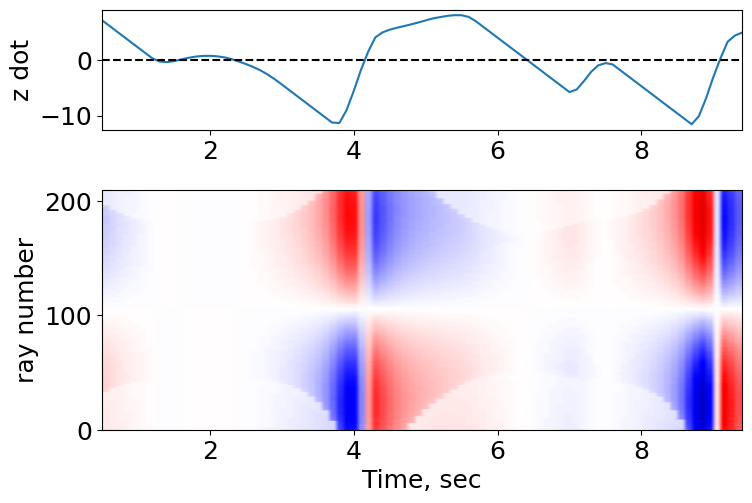

In [19]:
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_axes([0.2, 0.7, 0.8, 0.2])
ax2 = fig.add_axes([0.2, 0.2, 0.8, 0.4])

ax1.plot(trajec_constx_adj.time.values, trajec_constx_adj.z_dot.values)
ax1.set_xlim([trajec_constx_adj.time.values.min(), trajec_constx_adj.time.values.max()])
ax1.hlines(0, trajec_constx_adj.time.values.min(), trajec_constx_adj.time.values.max(),
           linestyles='--', colors='black')
ax1.set_ylabel('z dot')

ax2.imshow(optic_flows, vmin=-5, vmax=5, cmap='seismic', extent=[trajec_constz_adj.time.values.min(),
                                                                 trajec_constz_adj.time.values.max(),
                                                                 0, 210])
ax2.set_ylabel('ray number')
ax2.set_xlabel('Time, sec')

ax2.set_aspect('auto')

### Now look at the squiggle

/content/terrain_and_optic_flow_utility.py:147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trajec.z += altitude_adjustment
/content/terrain_and_optic_flow_utility.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trajec['ventral_altitude'] = trajec.z.values - ventral_elevation_array


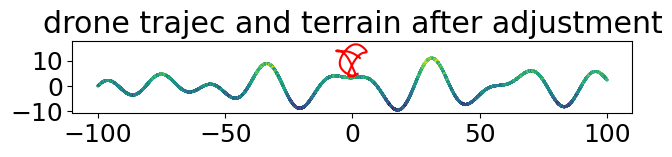

In [20]:
# plot trajec and terrain to verify
trajec_adj = terrain_and_optic_flow_utility.adjust_trajec_altitude(trajec_squiggle, terrain, plot=True)

In [21]:
# find optic flow and ray distances for the whole trajectory
imgs, optic_flows, ray_distances = terrain_and_optic_flow_utility.get_imgs_and_analytic_optic_flows(trajec_adj, terrain)

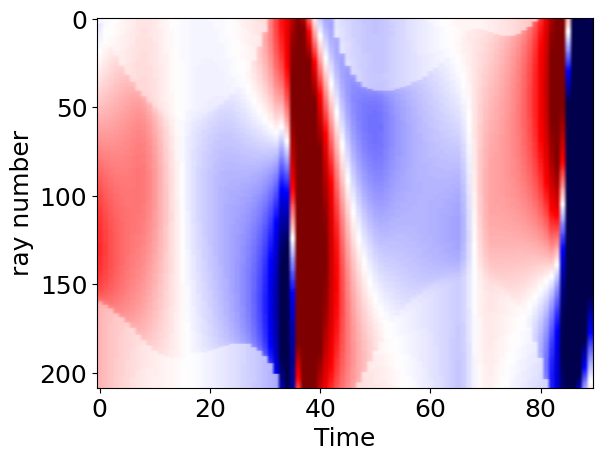

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.imshow(optic_flows, vmin=-3, vmax=3, cmap='seismic')
ax.set_ylabel('ray number')
ax.set_xlabel('Time')

ax.set_aspect('auto')

# Exercises / Thought Questions

1. Look at the optic flow for the big squiggle trajectory over a more complicated piece of the terrain -- i.e. a region with large changes in elevation.
2. How will we take full advantage of the optic flow information in an estimator? How many measurements do we have here?
3. If we include the full resolution of optic flow, what does that mean for the size of an estimator (e.g. a ANN or a UKF), and therefore the computation time? Do we need that full resolution?

# Generating a lot of trajectories

Running the main script of `../Utility/terrain_and_optic_flow_utility` will generate 3,000 trajectories, random terrain, and calculate the corresponding analytic optic flow and ray distances. A subset of these trajectories can be downloaded from this github repo. The complete subset is stored elsewhere...